In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score
import PIL.ImageOps    

### Boilerpalte

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    training_dir = "/home/care1e55/study/DBO/project/gpds/combined/combined/train"
    testing_dir = "/home/care1e55/study/DBO/project/gpds/combined/combined/test"
    training_csv="/home/care1e55/study/DBO/project/gpds/train_hard_triplet_data.csv"
    testing_csv="/home/care1e55/study/DBO/project/gpds/train_hard_triplet_data.csv"
    train_batch_size = 32
    train_number_epochs = 4

In [4]:
training_dir = "/home/care1e55/study/DBO/project/gpds/combined/combined/train"
testing_dir = "/home/care1e55/study/DBO/project/gpds/combined/combined/test"
training_csv="/home/care1e55/study/DBO/project/gpds/train_hard_triplet_data.csv"
testing_csv="/home/care1e55/study/DBO/project/gpds/train_hard_triplet_data.csv"


In [5]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [6]:
pd.read_csv(training_csv).head(2)

,sample
0,001gpds/c-001-01.jpg
1,001gpds/c-001-02.jpg


In [7]:
class HardTripletDataset():
    def __init__(self, base_path, transform=None):
        self.transform = transform
        self.genuie = []
        self.forged = []
        # self.base_path = './gpds/combined/combined'
        self.base_path = base_path
        self.dataframes = []
        files_list = []

        for root, dirs, files in tqdm(os.walk(self.base_path)):
            if files:
                self.dataframes.append([os.path.join(root.split("/")[-1], file) for file in files ])

        dataframes = self.dataframes
        for i in tqdm(range(len(dataframes))):
            if '_forg' not in dataframes[i][0]:
                cur_genuie = dataframes[i]
                for j, dataframe in enumerate(dataframes):
                    if dataframes[i][0].split("/")[0]+"_forg" == dataframes[j][0].split("/")[0]:
                        cur_forg = dataframes[j]
                        break 
                self.genuie.append(cur_genuie)
                self.forged.append(cur_forg)

    def __len__(self):
        return int(len(self.dataframes)//2)
    
    def __getitem__(self, index):
        cur_genuie = self.genuie[index]
        cur_forged = self.forged[index]
        anchor_indx = np.random.randint(23)
        positive_indx = np.random.randint(23)
        negative_indx = np.random.randint(29)
        cur_genuie_batch = self.prepare_one(cur_genuie[anchor_indx])
        cur_positive_batch = self.prepare_one(cur_genuie[positive_indx])
        cur_forged_batch = self.prepare_one(cur_forged[negative_indx])
        return cur_genuie_batch, cur_positive_batch, cur_forged_batch
    

    def prepare_batch(self, batch):
        for n, i in enumerate(batch):
            cur_img = Image.open(os.path.join(self.base_path,i)).convert('L')
            cur_img = PIL.ImageOps.invert(cur_img)
            cur_img = cur_img.convert('RGB')
            cur_img.load()
            if self.transform is not None:
                cur_img = self.transform(cur_img)
            if n == 0:
                prepared_batch = cur_img.unsqueeze(0)
            else:
                prepared_batch = torch.cat((prepared_batch, cur_img.unsqueeze(0)), 0)            
        return prepared_batch

    
    def prepare_one(self, one):
        cur_img = Image.open(os.path.join(self.base_path,one)).convert('L')
        cur_img = PIL.ImageOps.invert(cur_img)
        cur_img = cur_img.convert('RGB')
        cur_img.load()
        if self.transform is not None:
            cur_img = self.transform(cur_img)
        return cur_img
    

In [8]:
transform = transforms.Compose([
    # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
    # transforms.RandomHorizontalFlip(),
    # transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
    # transforms.RandomRotation(degrees = 10, fill=255),
    # transforms.RandomRotation(degrees = 20),
    # transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
    # transforms.RandomRotation(degrees = 15, fill=0),
    # transforms.RandomAffine(degrees=(-10, 10), translate=None, scale=None, shear=(-10,10), resample=False, fillcolor=(0,0,0)),
    # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.95, 1.05)),
    transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
    # transforms.Resize((448,448)),
    # transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.9, 1.4)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [9]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

    # for param in model.layer3.parameters():
    #   param.requires_grad = True
    
    # for param in model.layer4.parameters():
    #   param.requires_grad = True

    # for param in model.avgpool.parameters():
    #   param.requires_grad = True

    # for param in model.fc.parameters():
    #   param.requires_grad = True

In [10]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        # self.resnet = models.resnet50(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
        self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 128),
                # nn.Linear(num_ftrs, 512),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # nn.Linear(512, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout2d(p=0.5),
                # # nn.Linear(128,16)
                # nn.Linear(128,2)
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    def forward(self, input1, input2, input3):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        output3 = self.forward_once(input3)
        return output1, output2, output3

    def inference(self, x):
        with torch.no_grad():
            output = self.resnet(x)
            return output

In [11]:
net = SiameseNetwork().cuda()

In [12]:
train_datasdet = HardTripletDataset(training_dir, transform=transform)

19801it [00:01, 14558.67it/s]
100%|██████████| 19800/19800 [00:51<00:00, 388.10it/s]


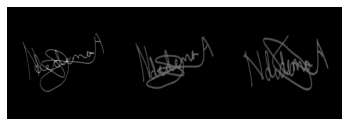

In [13]:
vis_dataloader = DataLoader(train_datasdet, shuffle=True, batch_size=1)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))

In [14]:
print(net)

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [15]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [16]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [17]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    log_template = "\nIteration {ep:03d} train_loss: {t_loss:0.4f}"  
    
    for i, data in tqdm(enumerate(train_loader,0), total = len(train_loader)):
        img0, img1, img2 = data
        img0, img1, img2 = img0.cuda(), img1.cuda() , img2.cuda()
        optimizer.zero_grad()
        output1, output2, output3 = net(img0, img1, img2)
        loss_contrastive = criterion(output1, output2, output3)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
          
    train_loss = running_loss / processed_data

    return train_loss

In [18]:
def train(train_files, net, epochs, batch_size):
    train_dataloader = DataLoader(train_files,
                        shuffle=True,
                        num_workers=4,
                        batch_size=batch_size)

    history = []
   
    opt = optim.AdamW(net.parameters(), lr=0.05)
    scheduler = StepLR(opt, step_size=1, gamma=0.5)
    criterion = TripletLoss()
    # criterion = nn.TripletMarginLoss(margin = 100.0, p = 1.0, eps = 1e-06, swap = False, size_average=None, reduce=None, reduction = 'mean')

    for epoch in range(epochs):
        print("Epoch:", epoch)
        train_loss = fit_epoch(net, train_dataloader, criterion, opt)
        print("loss:", train_loss)
        
        scheduler.step()
        history.append((train_loss))
                 
    return history

In [19]:
history = train(train_datasdet, net=net, epochs=Config.train_number_epochs, batch_size=Config.train_batch_size)

Epoch: 0
100%|██████████| 310/310 [04:31<00:00,  1.14it/s]
loss: 685.3701855757743
Epoch: 1
100%|██████████| 310/310 [04:52<00:00,  1.06it/s]loss: 0.8506241291701192
Epoch: 2

100%|██████████| 310/310 [04:55<00:00,  1.05it/s]
loss: 0.187113037109375
Epoch: 3
100%|██████████| 310/310 [04:58<00:00,  1.04it/s]loss: 0.05303875740128334



In [20]:
torch.save(net.state_dict(), "model_random_sampling_clean.pt")
print("Model Saved Successfully")

Model Saved Successfully


In [21]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
            #   transforms.RandomHorizontalFlip(),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 20),
            #   transforms.RandomRotation(degrees = 10),
            #   transforms.RandomResizedCrop(RESCALE_SIZE, scale=(0.7, 1.0)),
              # transforms.Pad((50,50), fill=(0,0,0), padding_mode='constant'),
              transforms.ToTensor(),
              # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
          ])

In [22]:
test_dataset = HardTripletDataset(testing_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

201it [00:00, 2571.16it/s]
100%|██████████| 200/200 [00:00<00:00, 8246.36it/s]


In [23]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
# threshhold = torch.FloatTensor([50.0]).cuda()
threshhold = torch.FloatTensor([25.0]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1, x3 = data
    output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
    eucledian_distance1 = F.pairwise_distance(output1, output2)
    eucledian_distance2 = F.pairwise_distance(output1, output3)
    
    targets.append(0)
    targets.append(1)
    
    if eucledian_distance1 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

    if eucledian_distance2 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

100%|██████████| 100/100 [00:07<00:00, 13.80it/s]


In [24]:
from sklearn.metrics import f1_score

In [25]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.79

In [26]:
f1_score(n_targets, n_predictions, average='weighted')

0.7886473429951689

In [27]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.1830985915492958

In [28]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
    

1.16

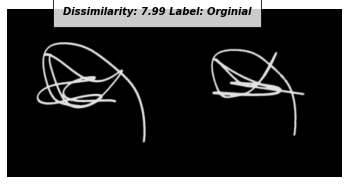

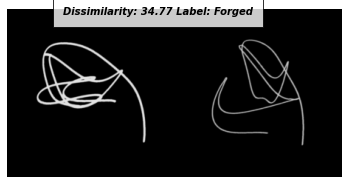

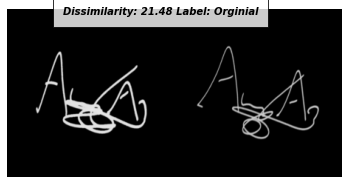

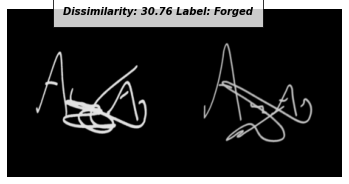

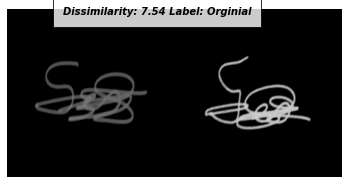

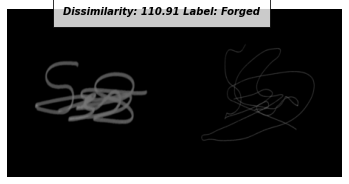

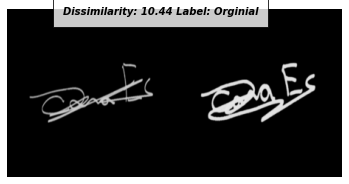

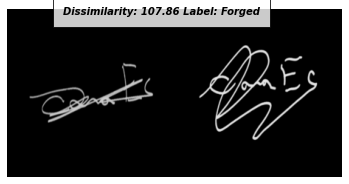

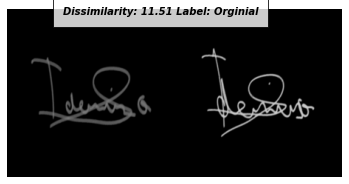

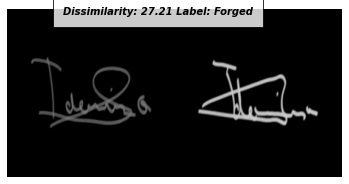

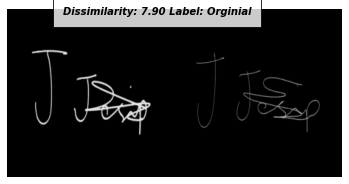

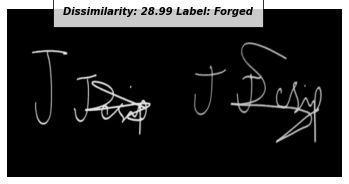

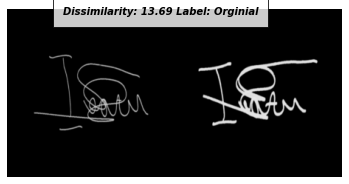

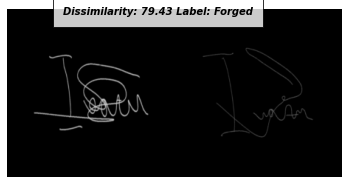

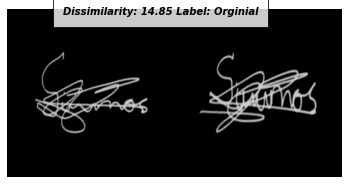

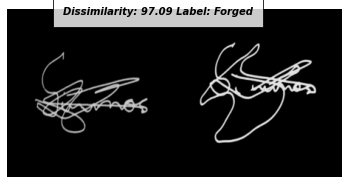

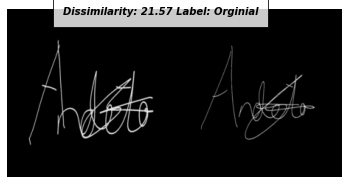

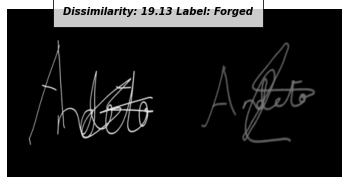

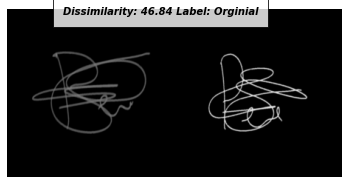

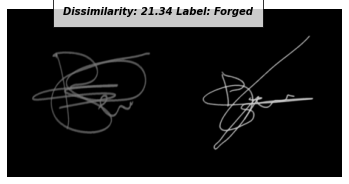

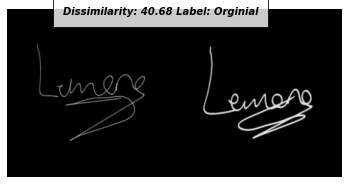

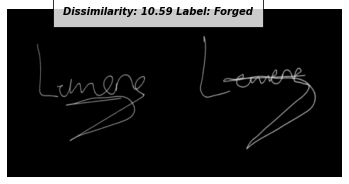

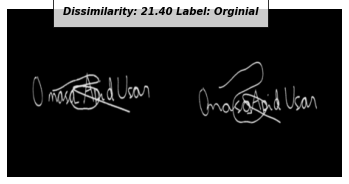

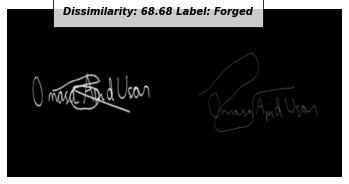

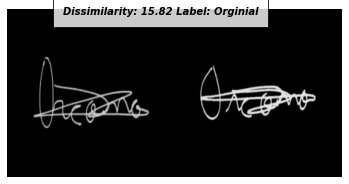

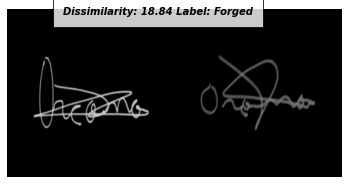

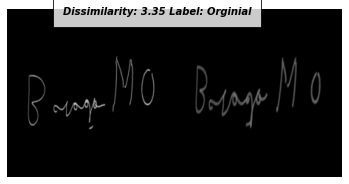

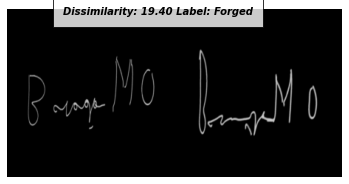

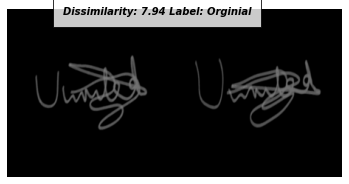

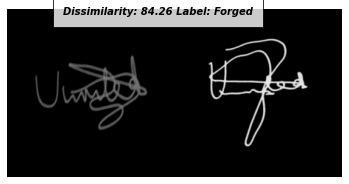

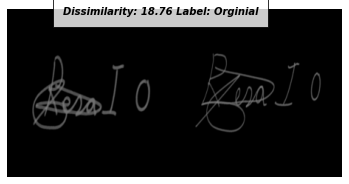

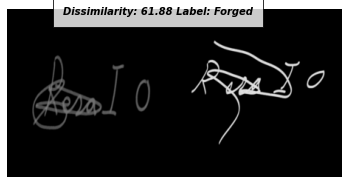

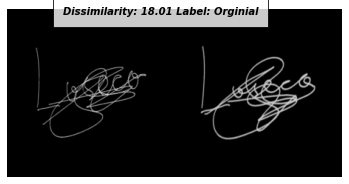

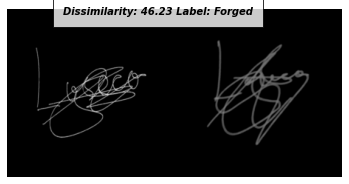

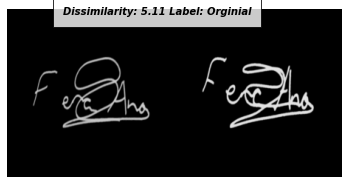

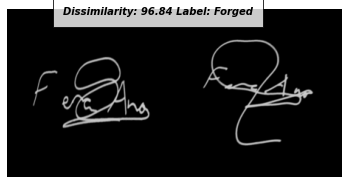

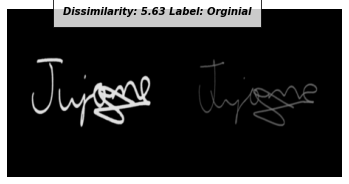

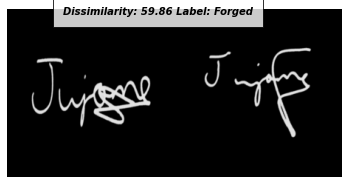

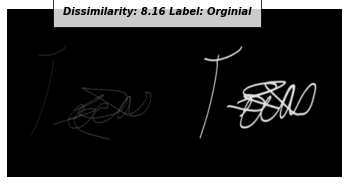

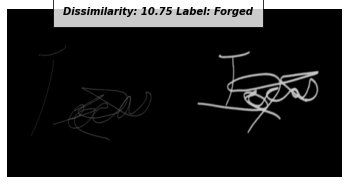

In [29]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 ,x3 = data
  concatenated1 = torch.cat((x0,x1),0)
  concatenated2 = torch.cat((x0,x3),0)
  output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
  eucledian_distance1 = F.pairwise_distance(output1, output2)
  eucledian_distance2 = F.pairwise_distance(output1, output3)
  label="Orginial"
  imshow(torchvision.utils.make_grid(concatenated1),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance1.item(),label))
  label="Forged"
  imshow(torchvision.utils.make_grid(concatenated2),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance2.item(),label))
  counter=counter+1
  if counter ==20:
     break